In [1]:
%env SPARK_HOME=/home/xcollazo/.conda/envs/spark33/lib/python3.10/site-packages/pyspark

env: SPARK_HOME=/home/xcollazo/.conda/envs/spark33/lib/python3.10/site-packages/pyspark


In [2]:
%env SPARK_CONF_DIR=/etc/spark3/conf

env: SPARK_CONF_DIR=/etc/spark3/conf


In [3]:
!echo $SPARK_HOME
!echo $SPARK_CONF_DIR

/home/xcollazo/.conda/envs/spark33/lib/python3.10/site-packages/pyspark
/etc/spark3/conf


In [ ]:
import wmfdata
spark = wmfdata.spark.create_custom_session(
    master='yarn',
    spark_config={
        "spark.shuffle.service.name": 'spark_shuffle_3_3',
        "spark.shuffle.service.port": '7338',
        "spark.yarn.archive": "hdfs:///user/spark/share/lib/spark-3.3.2-assembly.zip",
        "spark.dynamicAllocation.maxExecutors": 16,
        "spark.executor.memory": "42g",
        "spark.driver.memory": "42g",
        "spark.driver.cores": "4",
        ##
        # extras to make Iceberg and MariaDB work on 3.3.2:
        ##
        "spark.jars.packages": "org.apache.iceberg:iceberg-spark-runtime-3.3_2.12:1.2.1,com.mysql:mysql-connector-j:8.2.0",
        "spark.jars.ivySettings": "/etc/maven/ivysettings.xml",  # fix jar pulling
    }
)

In [7]:
import argparse
import dns.resolver
import subprocess
import sys

In [16]:
def df_from_mariadb_replica_partitioned(spark, query, min, max, num_partitions, wiki_db, host, port, pw):
    return (spark.read
            .format("jdbc")
            .option("driver", "com.mysql.cj.jdbc.Driver")
            .option('numPartitions', num_partitions)
            .option("partitionColumn", "revision_timestamp")
            .option("lowerBound", min)
            .option("upperBound", max)
            .option("url", f"jdbc:mysql://{host}:{port}/{wiki_db}")
            .option("dbtable", f"({query}) t")
            .option("user", "research")
            .option("password", pw)
            .load())


In [30]:
def do_emit_mismatch_rows(
        spark,
        wiki_db,
        target_table,
        min_timestamp,
        max_timestamp,
        num_partitions,
        host,
        port,
        pw
) -> None:

    #
    # Fetch all revisions in a time window from a particular wiki_db,
    # while making sure to use the rev_timestamp index
    #
    source_revisions_sql = f"""
SELECT rev_id                          AS revision_id,
       CAST(rev_timestamp as DATETIME) AS revision_timestamp,
       rev_deleted & 1 = 0             AS revision_content_is_visible,
       rev_deleted & 2 = 0             AS user_is_visible,
       rev_deleted & 4 = 0             AS revision_comment_is_visible,
       rev_len                         AS revision_size,
       rev_sha1                        AS revision_sha1
FROM revision
WHERE rev_timestamp >= TO_CHAR(TIMESTAMP '{min_timestamp}', 'YYYYMMDDHH24MISS')
  AND rev_timestamp  < TO_CHAR(TIMESTAMP '{max_timestamp}', 'YYYYMMDDHH24MISS')
"""

    print(f"Fetching source revisions from a time window of {wiki_db}:")
    print(source_revisions_sql)

    source_revisions_sql_df = df_from_mariadb_replica_partitioned(
        spark,
        source_revisions_sql,
        min_timestamp,
        max_timestamp,
        num_partitions,
        wiki_db,
        host,
        port,
        pw
    )
    source_revisions_sql_df.createOrReplaceTempView("source_revisions")

    target_revisions_sql = f"""
SELECT revision_id,
       revision_timestamp,
       revision_content_is_visible,
       user_is_visible,
       revision_comment_is_visible,
       revision_size,
       revision_sha1
FROM {target_table}
WHERE wiki_db = '{wiki_db}'
  AND revision_timestamp >= TIMESTAMP '{min_timestamp}'
  AND revision_timestamp  < TIMESTAMP '{max_timestamp}'
    """

    print(f"Fetching target revisions from a time window of {wiki_db}:")
    print(target_revisions_sql)

    target_revisions_sql_df = spark.sql(target_revisions_sql)
    target_revisions_sql_df.createOrReplaceTempView("target_revisions")

    emit_mismatch_rows_sql = f"""
SELECT '{wiki_db}'     AS wiki_db,
       s.revision_id,
       s.revision_timestamp,
       'Missing from target' as reason
FROM source_revisions s
ANTI JOIN target_revisions t
ON (s.revision_id = t.revision_id)

UNION ALL

SELECT '{wiki_db}'     AS wiki_db,
       s.revision_id,
       s.revision_timestamp,
       CASE
         WHEN s.revision_content_is_visible != t.revision_content_is_visible THEN 'Revision visibility mismatch'
         WHEN s.user_is_visible != t.user_is_visible THEN 'User visibility mismatch'
         WHEN s.revision_comment_is_visible != t.revision_comment_is_visible THEN 'Comment visibility mismatch'
         WHEN s.revision_sha1 != t.revision_sha1 THEN 'Revision sha1 mismatch'
         WHEN s.revision_size != t.revision_size THEN 'Revision size mismatch'
         ELSE 'Error!'
       END AS reason
FROM source_revisions s
INNER JOIN target_revisions t ON (s.revision_id = t.revision_id)
WHERE s.revision_content_is_visible != t.revision_content_is_visible
   OR s.user_is_visible != t.user_is_visible
   OR s.revision_comment_is_visible != t.revision_comment_is_visible
   OR s.revision_sha1 != t.revision_sha1
   OR s.revision_size != t.revision_size
    """

    print("Calculating mismatched rows via:")
    print(emit_mismatch_rows_sql)

    emit_mismatch_rows_sql_df = spark.sql(emit_mismatch_rows_sql)
    emit_mismatch_rows_sql_df.createOrReplaceTempView("results")
    # spark.sql(emit_mismatch_rows_sql).show(5000, truncate=False)


In [31]:
do_emit_mismatch_rows(
    spark,
    'enwiki',
    'wmf_dumps.wikitext_raw_rc2',
    '2021-01-01 00:00:00',    
    '2022-01-01 00:00:00',
    '8', # this control how many Spark partitions are generated, and how many parallel conecctions to the db as well.
    'dbstore1008.eqiad.wmnet',
    '3311',
    'redacted'
)

Fetching source revisions from a time window of enwiki:

SELECT rev_id                          AS revision_id,
       CAST(rev_timestamp as DATETIME) AS revision_timestamp,
       rev_deleted & 1 = 0             AS revision_content_is_visible,
       rev_deleted & 2 = 0             AS user_is_visible,
       rev_deleted & 4 = 0             AS revision_comment_is_visible,
       rev_len                         AS revision_size,
       rev_sha1                        AS revision_sha1
FROM revision
WHERE rev_timestamp >= TO_CHAR(TIMESTAMP '2021-01-01 00:00:00', 'YYYYMMDDHH24MISS')
  AND rev_timestamp  < TO_CHAR(TIMESTAMP '2022-01-01 00:00:00', 'YYYYMMDDHH24MISS')

Fetching target revisions from a time window of enwiki:

SELECT revision_id,
       revision_timestamp,
       revision_content_is_visible,
       user_is_visible,
       revision_comment_is_visible,
       revision_size,
       revision_sha1
FROM wmf_dumps.wikitext_raw_rc2
WHERE wiki_db = 'enwiki'
  AND revision_timestamp >= T

In [14]:
# only need to run once to CREATE sink table.
spark.sql("""
CREATE TABLE xcollazo.missing_or_innaccurate_rows(
    wiki_db STRING,
    revision_id BIGINT,
    revision_timestamp TIMESTAMP,
    reason STRING
) USING ICEBERG
""")

DataFrame[]

In [21]:
# this triggers the whole pipeline and INSERTs
spark.sql("""
INSERT INTO xcollazo.missing_or_innaccurate_rows
SELECT *
FROM results
""")

DataFrame[]

In [9]:
# example of how emitted hows look
spark.sql("""
SELECT *
FROM xcollazo.missing_or_innaccurate_rows
""").show(truncate=False)

+-------+-----------+-------------------+-------------------+
|wiki_db|revision_id|revision_timestamp |reason             |
+-------+-----------+-------------------+-------------------+
|enwiki |1197204700 |2024-01-19 15:21:19|Missing from target|
|enwiki |1197958828 |2024-01-22 16:00:09|Missing from target|
|enwiki |1204309393 |2024-02-06 21:53:43|Missing from target|
|enwiki |1210386120 |2024-02-26 10:24:56|Missing from target|
|enwiki |1210387525 |2024-02-26 10:37:31|Missing from target|
|enwiki |1221618863 |2024-05-01 00:01:19|Missing from target|
|enwiki |1221619036 |2024-05-01 00:02:14|Missing from target|
|enwiki |1221619079 |2024-05-01 00:02:27|Missing from target|
|enwiki |1221619136 |2024-05-01 00:02:44|Missing from target|
|enwiki |1221619161 |2024-05-01 00:02:52|Missing from target|
|enwiki |1221619176 |2024-05-01 00:02:56|Missing from target|
|enwiki |1221619203 |2024-05-01 00:03:03|Missing from target|
|enwiki |1221619324 |2024-05-01 00:03:40|Missing from target|
|enwiki 

In [22]:
# some summary stats
spark.sql("""
SELECT count(1) as count,
       reason
FROM xcollazo.missing_or_innaccurate_rows
GROUP BY reason
ORDER BY count DESC
""").show(truncate=False)

+------+----------------------------+
|count |reason                      |
+------+----------------------------+
|454706|Missing from target         |
|337256|Revision sha1 mismatch      |
|2144  |User visibility mismatch    |
|190   |Revision visibility mismatch|
|28    |Comment visibility mismatch |
+------+----------------------------+



In [24]:
# do some fancy figures
pandas_df = spark.sql("""
SELECT count(1) as count,
       date_trunc('DAY', revision_timestamp) day,
       reason
FROM xcollazo.missing_or_innaccurate_rows
GROUP BY day, reason
ORDER BY day ASC
""").toPandas()

In [25]:
pandas_df_pivoted = pandas_df.pivot_table(index='day',
                columns='reason',
                values='count',
                fill_value=0)

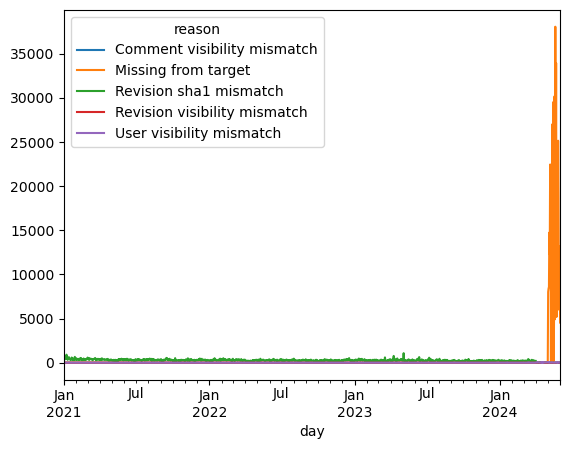

In [26]:
# how does the whole timeline that was analyzed look?
# note all the missing events as of late. we will take a look at this issue later.
import matplotlib.pyplot as plt

p = pandas_df_pivoted.plot(y=['Comment visibility mismatch',
                          'Missing from target',
                          'Revision sha1 mismatch',
                          'Revision visibility mismatch',
                          'User visibility mismatch'])
plt.yscale('linear')

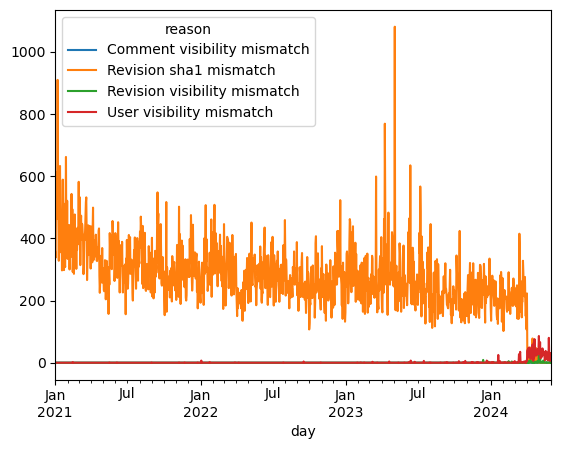

In [27]:
# missing rows obscure other issues. let's remove them from the plot to see
# better other issues:
import matplotlib.pyplot as plt

p = pandas_df_pivoted.plot(y=['Comment visibility mismatch',
                          'Revision sha1 mismatch',
                          'Revision visibility mismatch',
                          'User visibility mismatch'])
plt.yscale('linear')